In [144]:
import os

import numpy as np
from PIL import Image
from tqdm import tqdm 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage.transform import resize
from keras import backend as K
from keras.models import Model
from keras.utils import conv_utils
from keras.engine.topology import Layer
from keras.callbacks import TensorBoard
from keras.datasets import mnist, cifar10
from keras.layers import Input, Conv2D, PReLU, BatchNormalization, Add

# Data preprocessing

## Load CIFAR

In [4]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train.shape, y_train.shape

((50000, 32, 32, 3), (50000, 1))

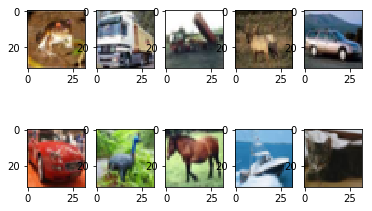

In [3]:
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(x_train[i])
    
plt.show()

## Prepare LR CIFAR

In [104]:
x_train.shape

(50000, 32, 32, 3)

In [136]:
def images_resize(images, ratio):
    lr_width = images.shape[1] // ratio
    lr_height = images.shape[2] // ratio
    resized = np.zeros((images.shape[0], lr_width, lr_height, images.shape[3]))
    for i in tqdm(range(images.shape[0])):
        resized[i] = resize(images[i], (lr_width, lr_height))
        
    return resized

In [138]:
x_train_lr = images_resize(x_train, 2)
x_test_lr = images_resize(x_test, 2)


  0%|          | 0/50000 [00:00<?, ?it/s]/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "

  2%|▏         | 1162/50000 [00:01<00:51, 957.53it/s]
Exception in thread Thread-5:
Traceback (most recent call last):
  File "/usr/lib/python3.5/threading.py", line 914, in _bootstrap_inner
    self.run()
  File "/usr/local/lib/python3.5/dist-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/usr/lib/python3.5/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration

100%|██████████| 10000/10000 [00:09<00:00, 1096.42it/s]


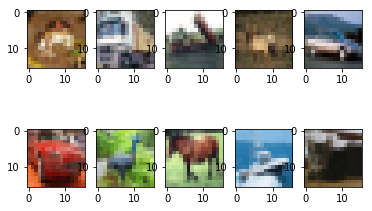

In [139]:
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(x_train_lr[i])
    
plt.show()

# Network description 

![](srgan_architecture.png)

## Generator network

1. Input - Image LR
2. Conv, kernel 3x3, 64 feature maps, what's s1?
3. ParametricReLU
4. B=16 residual blocks
    1. Conv with 3x3 kernel, 64 feature maps and stride 1
    2. Batch Normalization (https://keras.io/layers/normalization/)
    3. ParametricReLU
    4. Conv with 3x3 kernel, 64 feature maps and stride 1
    5. Batch Normalization
    6. Elementwise sum (https://keras.io/layers/merge/ add)
5. Conv with 3x3 kernel, 64 feature maps and stride 1
6. Batch Normalization
7. Elementwise sum (https://keras.io/layers/merge/ add)
8. Shuffle block x2 (? how it's called ?)
    1. Conv with 3x3 kernel, 256 feature maps and stride 1
    2. PixelShuffler x2 https://gist.github.com/t-ae/6e1016cc188104d123676ccef3264981
    3. ParametricReLU
9. Conv with 9x9 kernel, 3 feature maps and stride 1
10. Estimated SR (super-resolved) image

Is the padding `same` a correct one? Otherwise the dims are not the same
Is the number of pixel shufflers the scaling ratio? 

In [140]:
# from https://gist.github.com/t-ae/6e1016cc188104d123676ccef3264981

class PixelShuffler(Layer):
    def __init__(self, size=(2, 2), data_format=None, **kwargs):
        super(PixelShuffler, self).__init__(**kwargs)
        self.data_format = conv_utils.normalize_data_format(data_format)
        self.size = conv_utils.normalize_tuple(size, 2, 'size')

    def call(self, inputs):

        input_shape = K.int_shape(inputs)
        if len(input_shape) != 4:
            raise ValueError('Inputs should have rank ' +
                             str(4) +
                             '; Received input shape:', str(input_shape))

        if self.data_format == 'channels_first':
            batch_size, c, h, w = input_shape
            if batch_size is None:
                batch_size = -1
            rh, rw = self.size
            oh, ow = h * rh, w * rw
            oc = c // (rh * rw)

            out = K.reshape(inputs, (batch_size, rh, rw, oc, h, w))
            out = K.permute_dimensions(out, (0, 3, 4, 1, 5, 2))
            out = K.reshape(out, (batch_size, oc, oh, ow))
            return out

        elif self.data_format == 'channels_last':
            batch_size, h, w, c = input_shape
            if batch_size is None:
                batch_size = -1
            rh, rw = self.size
            oh, ow = h * rh, w * rw
            oc = c // (rh * rw)

            out = K.reshape(inputs, (batch_size, h, w, rh, rw, oc))
            out = K.permute_dimensions(out, (0, 1, 3, 2, 4, 5))
            out = K.reshape(out, (batch_size, oh, ow, oc))
            return out

    def compute_output_shape(self, input_shape):

        if len(input_shape) != 4:
            raise ValueError('Inputs should have rank ' +
                             str(4) +
                             '; Received input shape:', str(input_shape))

        if self.data_format == 'channels_first':
            height = input_shape[2] * self.size[0] if input_shape[2] is not None else None
            width = input_shape[3] * self.size[1] if input_shape[3] is not None else None
            channels = input_shape[1] // self.size[0] // self.size[1]

            if channels * self.size[0] * self.size[1] != input_shape[1]:
                raise ValueError('channels of input and size are incompatible')

            return (input_shape[0],
                    channels,
                    height,
                    width)

        elif self.data_format == 'channels_last':
            height = input_shape[1] * self.size[0] if input_shape[1] is not None else None
            width = input_shape[2] * self.size[1] if input_shape[2] is not None else None
            channels = input_shape[3] // self.size[0] // self.size[1]

            if channels * self.size[0] * self.size[1] != input_shape[3]:
                raise ValueError('channels of input and size are incompatible')

            return (input_shape[0],
                    height,
                    width,
                    channels)

    def get_config(self):
        config = {'size': self.size,
                  'data_format': self.data_format}
        base_config = super(PixelShuffler, self).get_config()

        return dict(list(base_config.items()) + list(config.items()))

In [141]:
input_shape = (16, 16, 3)
kernel_size = (3, 3)
kernel_size_last = (9, 9)
features = 64
features_shuffle = 256
features_last = 3
B = 16

# 1, 2, 3
input_1 = Input(shape=input_shape)
conv2d_2 = Conv2D(filters=features, kernel_size=kernel_size, strides=(1, 1), padding='same')(input_1)
prelu_3 = PReLU()(conv2d_2)

# 4 - residual blocks
last_layer = prelu_3
for _ in range(B):
    conv2d_4_A = Conv2D(filters=features, kernel_size=kernel_size, strides=(1, 1), padding='same')(last_layer)
    bn_4_B = BatchNormalization()(conv2d_4_A)
    prelu_4_C = PReLU()(bn_4_B)
    conv2d_4_D = Conv2D(filters=features, kernel_size=kernel_size, strides=(1, 1), padding='same')(prelu_4_C)
    bn_4_E = BatchNormalization()(conv2d_4_D)
    add_4_F = Add()([last_layer, bn_4_E])
    
    last_layer = add_4_F
    
# 5, 6, 7
conv2d_5 = Conv2D(filters=features, kernel_size=kernel_size, strides=(1, 1), padding='same')(last_layer)
bn_6 = BatchNormalization()(conv2d_5)
add_7 = Add()([prelu_3, bn_6])

# 8 - shuffle block
last_layer = add_7
for _ in range(1):
    conv2d_8_A = Conv2D(filters=features_shuffle, kernel_size=kernel_size, strides=(1, 1), padding='same')(last_layer)
    shuffler_8_B = PixelShuffler()(conv2d_8_A)
    prelu_8_C = PReLU()(shuffler_8_B)
    
    last_layer = prelu_8_C
    
# 9 
conv2d_5 = Conv2D(filters=features_last, kernel_size=kernel_size_last, strides=(1, 1), 
                  padding='same')(last_layer)

In [142]:
model_generator = Model(input_1, conv2d_5)
model_generator.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])

In [145]:
tb_callback = TensorBoard(log_dir='data/tensorboard/', histogram_freq=0, write_graph=True, write_images=True)

In [143]:
model_generator.fit(x_train_lr, x_train, epochs=5, validation_data=(x_test_lr, x_test), callbacks=[tb_callback])

Train on 50000 samples, validate on 10000 samples
Epoch 1/5
11104/50000 [=====>........................] - ETA: 191s - loss: 1261.1938 - acc: 0.5772

KeyboardInterrupt: 